# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm

import optimization
import plotting

import warnings
warnings.filterwarnings("ignore")

# Data & Constants

In [2]:
# constants
start_date = "2019-12-01"  # 5 years worth of data (60 entries)
N = 48
risk_free = 0.4  # taken from latest observation of risk-free rate in Kenneth French Library

In [3]:
data_path = str(Path().absolute()) + "/data_will/48_industry_Portfolios.CSV"
df_global = pd.read_csv(data_path, index_col=0)
df_global.index = pd.to_datetime(df_global.index, format="%Y%m")  # clean the index to be datetime
df_global.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1926-07-01,2.37,0.12,-99.99,-5.19,1.29,8.65,2.50,50.21,-0.48,8.08,...,7.70,1.92,-23.79,0.07,1.87,4.61,-0.54,2.89,-5.77,5.20
1926-08-01,2.23,2.68,-99.99,27.03,6.50,16.81,-0.76,42.98,-3.58,-2.51,...,-2.38,4.85,5.39,-0.75,-0.13,11.83,2.57,5.30,0.32,6.76
1926-09-01,-0.57,1.58,-99.99,4.02,1.26,8.33,6.42,-4.91,0.73,-0.51,...,-5.54,0.08,-7.87,0.25,-0.56,-1.75,0.72,-3.06,-4.81,-3.86
1926-10-01,-0.46,-3.68,-99.99,-3.31,1.06,-1.40,-5.09,5.37,-4.68,0.12,...,-5.08,-2.62,-15.38,-2.20,-4.11,-11.82,-4.28,-5.74,-0.94,-8.49
1926-11-01,6.75,6.26,-99.99,7.29,4.55,0.00,1.82,-6.40,-0.54,1.87,...,3.84,1.61,4.67,6.52,4.33,-2.97,3.58,2.21,5.13,4.00


In [4]:
df_global = df_global.loc[df_global.index >= start_date, :]  # select last 5 years
df = df_global.loc[:, ["Whlsl", "Fin  ", "Util ", "Cnstr", "Hlth "]]  # select 5 assets to work with
rf = pd.DataFrame(risk_free, index=df.index, columns=["risk-free"])
df_rf = pd.concat([rf, df], axis=1)

# Question A1

Restricted license - for non-production use only - expires 2026-11-23


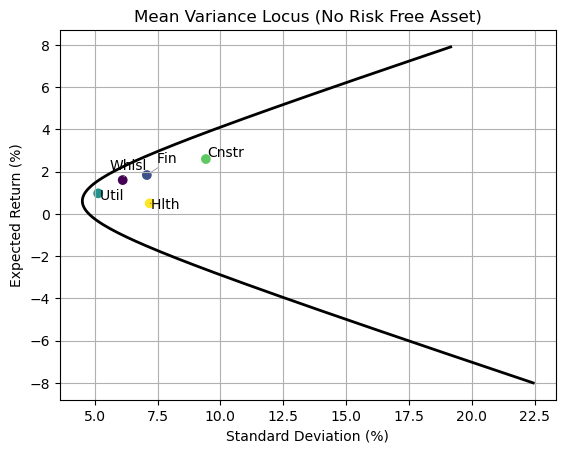

In [5]:
# QUESTION 1
# first and second moment
cov = df.cov()
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))

# set returns to target
target_returns = np.arange(-8, 8, 0.1)

# mean variance portfolio for each target return
response_no_rf, weights = optimization.mean_var_portfolio(df, target_returns, N, False, False, False, "gurobi")
plotting.mean_var_locus(response_no_rf[0], response_no_rf[1], std, mean, 'Mean Variance Locus (No Risk Free Asset)')


# Question A2

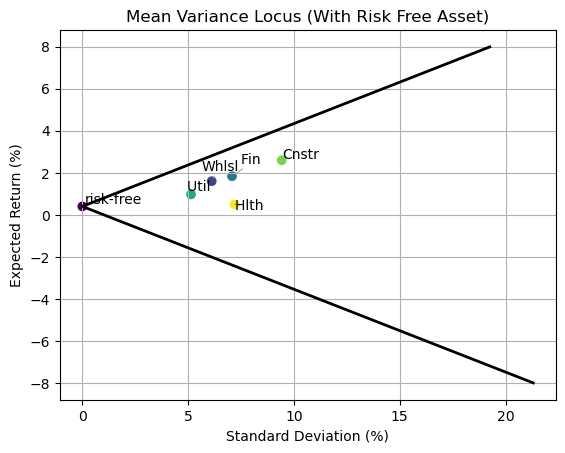

In [6]:
# nb assets
N = 5

# moments of returns
mean = df_rf.mean(axis=0)
std = np.sqrt(np.diag(df_rf.cov()))

# set returns to target
target_returns = np.arange(-8, 8, 0.01)

response_rf, weights = optimization.mean_var_portfolio(df_rf, target_returns, N, True, False, False, "gurobi")
plotting.mean_var_locus(response_rf[0], response_rf[1], std, mean, 'Mean Variance Locus (With Risk Free Asset)')


# Question A3

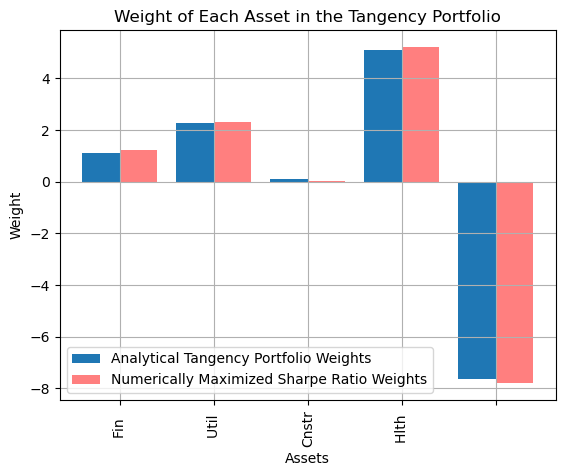

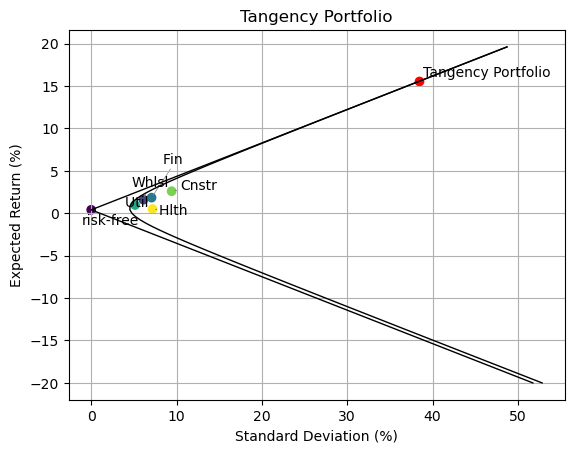

       Analytical Tangency Weights  Numerical Tangency Weights
Whlsl                     1.126621                    1.224965
Fin                       2.266788                    2.312914
Util                      0.121768                    0.041234
Cnstr                     5.109421                    5.215394
Hlth                     -7.624598                   -7.794508
                    Analytical  Numerical
Mean                 15.549801  15.904101
Standard Deviation   38.428183  39.328396


In [7]:
# nb assets
N = 6

# moments of returns
mean = df_rf.mean(axis=0)
std = np.sqrt(np.diag(df_rf.cov()))

# set returns to target
target_returns = np.arange(-20, 20, 0.4)

# the target return becomes a meaningless parameter when dealing with the tangency portfolio
# numerical procedure
response = optimization.tangency_portfolio(df, 0.4, False)

# analytical procedure
w, w_rfr = optimization.analytical_mean_var(mean[1:], cov, 0.05, 0.4, 5, True, True)

# display the weights
fig, ax = plt.subplots()
ax.grid()
x = np.arange(len(mean.index[1:]))
width = 0.4

ax.bar(x= x - width/2, height= w, width= width, label="Analytical Tangency Portfolio Weights")
ax.bar(x= x + width/2, height= response.x, width= width, alpha=0.5, color="red",
       label="Numerically Maximized Sharpe Ratio Weights")
ax.set_title("Weight of Each Asset in the Tangency Portfolio")
ax.set_xticklabels(mean.index[1:])
ax.set_xlabel("Assets")
ax.set_ylabel("Weight")
plt.xticks(rotation=90)
plt.legend()
plt.show()

# display the tangency portfolio on the mean variance locus
tangency_mean = w @ mean[1:]
tangency_std = np.sqrt(w @ cov @ w)

response_no_rf, weights = optimization.mean_var_portfolio(df, target_returns, N, False, False, False, "gurobi")
response_rf, weights = optimization.mean_var_portfolio(df_rf, target_returns, N, True, False, False, "gurobi")
plotting.tangency_plot(response_rf[0], response_rf[1], response_no_rf[0], response_no_rf[1], tangency_mean,
                       tangency_std, std, mean, "Tangency Portfolio")

print(pd.DataFrame(np.array([w, response.x]).T, index = df.columns, columns=["Analytical Tangency Weights", "Numerical Tangency Weights"]))
print(pd.DataFrame({"Analytical": [tangency_mean, tangency_std], "Numerical": [response.x @ mean[1:], np.sqrt(response.x @ cov @ response.x)]}, index=["Mean", "Standard Deviation"]))


# Question A4

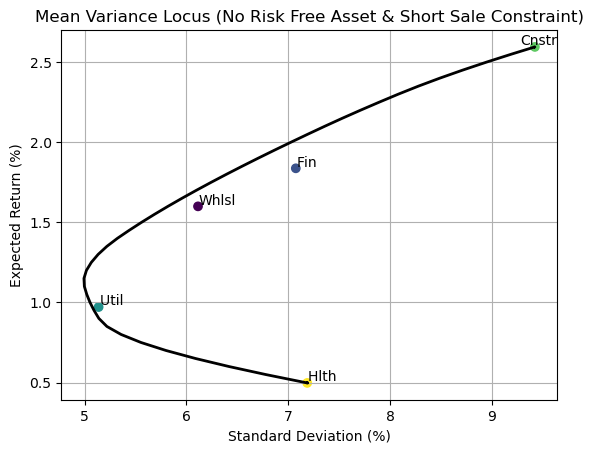

In [8]:
# nb assets
N = 5

# moments
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))

# returns to target
target_returns = np.arange(-8, 8, 0.05)
x_no_rf = []
y_no_rf = []
for ret in target_returns:
    response = optimization.minimize_variance(mean, cov, ret, N, False, True, False)
    x_no_rf.append(response.fun)
    y_no_rf.append(mean @ response.x)

# plot
plotting.mean_var_locus(x_no_rf, y_no_rf, std, mean, 'Mean Variance Locus (No Risk Free Asset & Short Sale Constraint)')


# Question A5

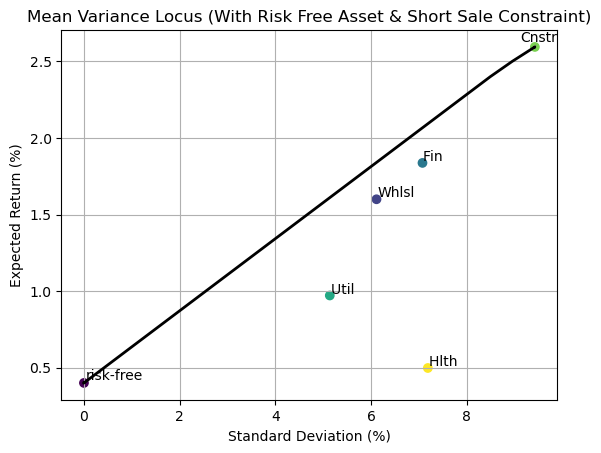

In [9]:
# nb assets
N = 6

# moments
mean = df_rf.mean(axis=0)
std = np.sqrt(np.diag(df_rf.cov()))

# returns to target
target_returns = np.arange(-8, 8, 0.1)
x_rf = []
y_rf = []
for ret in target_returns:
    response = optimization.minimize_variance(mean, cov, ret, N, True, True, False)
    x_rf.append(response.fun)
    y_rf.append(mean @ response.x)

# plot
plotting.mean_var_locus(x_rf, y_rf, std, mean, 'Mean Variance Locus (With Risk Free Asset & Short Sale Constraint)')


# Question A6

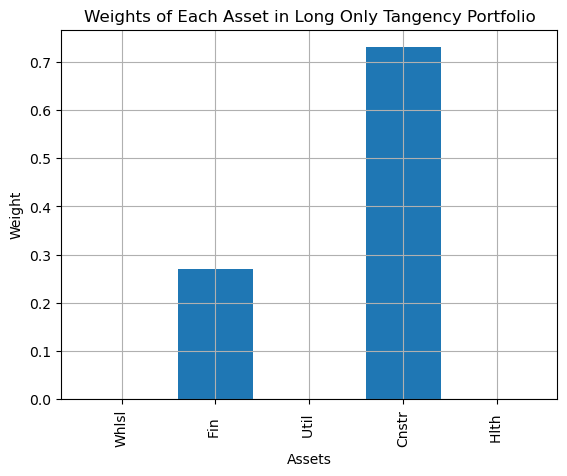

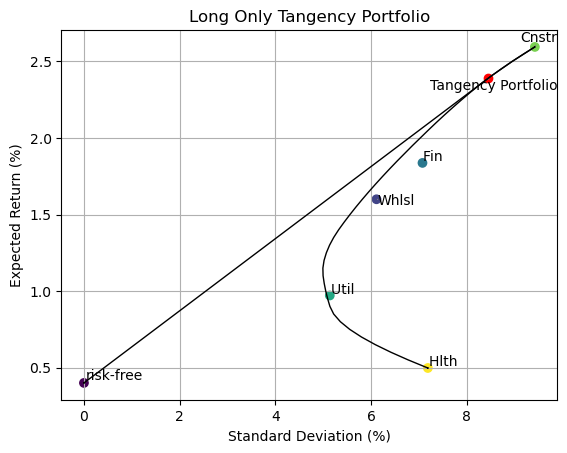

       Tangency Weights
Whlsl      1.387779e-17
Fin        2.698993e-01
Util       0.000000e+00
Cnstr      7.301007e-01
Hlth       9.020562e-17
                    Tangency Portfolio
Mean                          2.390340
Standard Deviation            8.447044


In [10]:
# nb of assets
N = 6

# moments
mean = df_rf.mean(axis=0)
std = np.sqrt(np.diag(df_rf.cov()))


# the target return becomes a meaningless parameter when dealing with the tangency portfolio
response = optimization.tangency_portfolio(df, 0.4, True)
w = response.x

fig, ax = plt.subplots()
ax.bar(x=mean[1:].index, height=w)
ax.set_title("Weights of Each Asset in Long Only Tangency Portfolio")
ax.set_xlabel("Assets")
ax.set_ylabel("Weight")
ax.grid()
plt.xticks(rotation=90)
plt.show()

plotting.tangency_plot(x_rf, y_rf, x_no_rf, y_no_rf, w @ mean[1:], np.sqrt(w @ cov @ w), std, mean,
                       "Long Only Tangency Portfolio")

print(pd.DataFrame(np.array([w]).T, index = df.columns, columns=["Tangency Weights"]))
print(pd.DataFrame({"Tangency Portfolio": [w @ mean[1:], np.sqrt(w @ cov @ w)]}, index=["Mean", "Standard Deviation"]))
